In [41]:
pip install newspaper3k

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install jpype1

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [58]:
from newspaper import Article
from konlpy.tag import Kkma
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np
%matplotlib inline
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [59]:
class SentenceTokenizer(object):
    def __init__(self):
        self.kkma = Kkma()
        self.Okt = Okt()
        self.stopwords = ['중인' ,'만큼', '마찬가지', '꼬집었', "연합뉴스", "데일리", "동아일보", "중앙일보", "조선일보", "기자"
,"아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가",]
    def url2sentences(self, url):
        article = Article(url, language='ko')
        article.download()
        article.parse()
        sentences = self.kkma.sentences(article.text)
        for idx in range(0, len(sentences)):
            if len(sentences[idx]) <= 10:
                sentences[idx-1] += (' ' + sentences[idx])
                sentences[idx] = ''
        return sentences
    def text2sentences(self, text):
        sentences = self.kkma.sentences(text)
        for idx in range(0, len(sentences)):
            if len(sentences[idx]) <= 10:
                sentences[idx-1] += (' ' + sentences[idx])
                sentences[idx] = ''
        return sentences
    def get_nouns(self, sentences):
        nouns = []
        for sentence in sentences:
            if sentence is not '':
                nouns.append(' '.join([nouns for nouns in self.Okt.nouns(str(sentence))
                                       if nouns not in self.stopwords and len(nouns) > 1]))
        return nouns
        

In [60]:
class GraphMatrix(object):
    def __init__(self):
        self.tfidf = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
        self.graph_sentence = []
    def build_sent_graph(self, sentence):
        tfidf_mat = self.tfidf.fit_transform(sentence).toarray()
        self.graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return self.graph_sentence
    def build_words_graph(self, sentence):
        cnt_vec_mat = normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word] : word for word in vocab}

In [61]:
class Rank(object):
    def get_ranks(self, graph, d=0.85): # d = damping factor
        A = graph
        matrix_size = A.shape[0]
        for id in range(matrix_size):
            A[id, id] = 0 # diagonal 부분을 0으로
            link_sum = np.sum(A[:,id]) # A[:, id] = A[:][id]
            if link_sum != 0:
                A[:, id] /= link_sum
            A[:, id] *= -d
            A[id, id] = 1
        B = (1-d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B) # 연립방정식 Ax = b
        return {idx: r[0] for idx, r in enumerate(ranks)}

In [62]:
class TextRank(object):
    def __init__(self, text):
        self.sent_tokenize = SentenceTokenizer()
        if text[:5] in ('http:', 'https'):
            self.sentences = self.sent_tokenize.url2sentences(text)
        else:
            self.sentences = self.sent_tokenize.text2sentences(text)
        self.nouns = self.sent_tokenize.get_nouns(self.sentences)
        self.graph_matrix = GraphMatrix()
        self.sent_graph = self.graph_matrix.build_sent_graph(self.nouns)
        self.words_graph, self.idx2word = self.graph_matrix.build_words_graph(self.nouns)
        self.rank = Rank()
        self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)
        self.word_rank_idx = self.rank.get_ranks(self.words_graph)
        self.sorted_word_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)
    def summarize(self, sent_num=1):
        summary = []
        index=[]
        for idx in self.sorted_sent_rank_idx[:sent_num]:
            index.append(idx)
        index.sort()
        for idx in index:
            summary.append(self.sentences[idx])
        return summary
    def keywords(self, word_num=5):
        rank = Rank()
        rank_idx = rank.get_ranks(self.words_graph)
        sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)
        keywords = []
        index=[]
        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
        #index.sort()
        for idx in index:
            keywords.append(self.idx2word[idx])
        return keywords

In [63]:
from PIL import Image
def draw_wordcloud(url): 
        news_text =''
        article = Article(url, language='ko')
        article.download()
        article.parse()
        article.text
        news_text = article.text
    
        engine = Okt() 
        nouns1 = engine.nouns(news_text)
        nouns1 = [n for n in nouns1 if len(n) > 1]

        # Counter: 단어수 세기, 가장 많이 등장한 단어(명사) 40개
        count = Counter(nouns1)
        tags = count.most_common(100)
        
        # 워드 클라우드 배경 사진
        book_mask = np.array(Image.open('1.png'))

        # WordCloud, matplotlib: 단어 구름 그리기
        font_path = 'E:\TextRank\KBLZ.ttf'
        wc = WordCloud(font_path=font_path, background_color='white', width=800, height=600, mask=book_mask)
        cloud = wc.generate_from_frequencies(dict(tags))
        plt.figure(figsize=(10,8))
        plt.axis('off')
        plt.imshow(cloud)

C:\Users\jungs\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


이에 앞서 구는 지난 4 월 카 이스트 소프트웨어교육센터와 '4 차 산업혁명시대, 서초 미래 인재 양성을 위한 업무 협약' 을 맺고 6월부터 '4 차 산업 서초 청년 취업 스쿨' 을 진행하고 있다.

keywords : ['청년', '진행', '취업', '이스트', '산업']


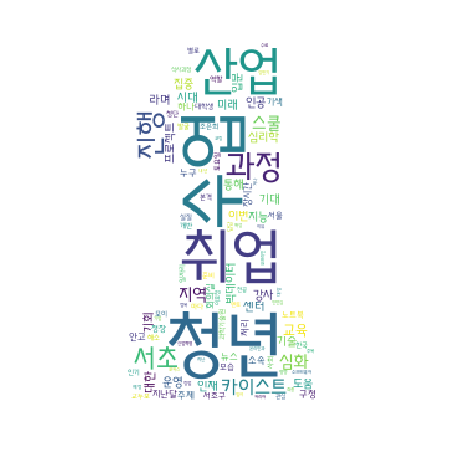

In [64]:
url = 'http://news1.kr/articles/?3710776'
textrank = TextRank(url)
for row in textrank.summarize(1):
    print(row)
    print()
print('keywords :',textrank.keywords())
draw_wordcloud(url)

In [65]:
import krwordrank

fname = 'E:\\TextRank\\daily.txt'

def get_texts_scores(fname):
    with open(fname, encoding='utf-8') as f:
        docs = [doc.replace('\n','').split('\n') for doc in f]
        if not docs:
            return []
        
        texts = docs
        return list(texts)
texts = get_texts_scores(fname)

In [66]:
texts = np.squeeze(texts)
print(texts)

['사랑해,처음 본 그 순간부터 사랑했고 너가 다른 남자와 행복하게 연애를 하는 순간에도 사랑했어.'
 ' 나는 너의 친한 친구이고 대학에서 만난 사람 중 가장 가까운 사람 중 하나다.'
 '널 사랑하지만 더 이상 다가가진 않을 것이다. 지금의 나는 너를 감당할 수 없기 때문이다.'
 '나는 잘 알고 있다, 예쁘고 착하고 다재다능한 너를 좋아하는 사람들이 얼마나 많은지.' '넌 뭘 먹고 자랐는지 그렇게 예쁠까.'
 '잘하는건 또 왜 그렇게 많은지.'
 '너의 글, 그림, 목소리, 생각, 말투, 춤, 흥얼거리는 노래, 작은 투정들, 시시콜콜한 얘기들, 작은 손, 동그란 얼굴, 취미, 꿈, 습관들... 그 모든 것을 사랑한다.'
 '너는 다정하다, 너는 상냥하고 따뜻하다.' '사랑스럽다.' '사랑스럽고 사랑스럽다.' '너를 마다할 남자가 있을까? 없다.'
 '너의 옆에는 항상 누군가 있었다.' '헤어졌다해도 바로 새로 생기는것을 보면 넌 정말로 모두에게 사랑스러운 사람인가보다.'
 '너의 주변만 봐도 알 수 있다.' '너가 얼마나 사랑받는 사람인지, 얼마나 많은 사람들이 너의 사랑을 받고싶어하는지.'
 '나도 그렇다.' '너의 사랑을 갖고싶다.'
 '눈을 뜨면 가장 먼저 보일 얼굴이 너의 그 예쁜 얼굴이었으면 좋겠고 잠들기전 마지막으로 볼 얼굴도 그 얼굴이었으면 좋겠다.'
 '너는 사랑스럽기도 하지만 가끔은 까칠하다.' '갑자기 날을 세우고 제멋대로 군다.' '바람같다.'
 '따뜻하게 보듬어주다가도 순식간에 태풍으로 변해 나를 숨막히게 한다.' '너는 네 자신이 변덕스럽다고 말한다.'
 '나는 그것마저 사랑한다.' '너의 따뜻함도 차가움도 모두 사랑한다.' '너의 밝음과 어두움, 그 모든 것을 사랑한다.'
 '애초에 너는 나의 삶을 파괴하고 들어왔었다.' '넌 나의 파괴적인 사랑이다.'
 '너의 섬세하고 거친 모습들, 한없이 사랑스럽다가도 한없이 차가워지는 모습들, 뭐 하나 놓치고 싶지 않다. 너의 존재 그 자체를 사랑해.'
 '그래서 나는 기다린다. 내가 너의 

# from krwordrank.word import KRWordRank

wordrank_extractor = KRWordRank(
    min_count = 2, # 단어의 최소 출현 빈도수 (그래프 생성 시)
    max_length = 10, # 단어의 최대 길이
    verbose = True
    )

beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10
verbose = True

keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter, verbose)

In [67]:
from krwordrank.sentence import summarize_with_sentences
text = texts # 라라랜드 영화평
keywords, sents = summarize_with_sentences(text, num_keywords=10, num_keysents=1)

In [68]:
print(sents)

['너는 나의 첫사랑이자 끝사랑이 되고 나는 너의 끝사랑이 되고싶다.']
